In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [11]:
meas_all = session.query(Measurement).all()
inspector = inspect(engine)
columns_measurement = inspector.get_columns('measurement')
for c in columns_measurement:
    print(c['name'], c["type"])
columns_station = inspector.get_columns('station')
for c in columns_station:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
latest = session.query(Measurement).order_by(Measurement.date.desc()).first()
print(latest.date)

2017-08-23


In [13]:
# Calculate the date 1 year ago from the last data point in the database
query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
query_date

datetime.date(2016, 8, 23)

In [14]:
# Perform a query to retrieve the data and precipitation scores

past_twelve = session.query(Measurement).filter(Measurement.date > '2016-08-23').all()

In [15]:
# Save the query results as a Pandas DataFrame and set the index to the date column
measurement_df = pd.DataFrame([vars(s)for s in past_twelve])
measurement_df.head()

,_sa_instance_state,tobs,date,prcp,station,id
0,<sqlalchemy.orm.state.InstanceState object at ...,79.0,2016-08-24,0.08,USC00519397,2365
1,<sqlalchemy.orm.state.InstanceState object at ...,80.0,2016-08-25,0.08,USC00519397,2366
2,<sqlalchemy.orm.state.InstanceState object at ...,79.0,2016-08-26,0.00,USC00519397,2367
3,<sqlalchemy.orm.state.InstanceState object at ...,77.0,2016-08-27,0.00,USC00519397,2368
4,<sqlalchemy.orm.state.InstanceState object at ...,78.0,2016-08-28,0.01,USC00519397,2369


<BarContainer object of 2223 artists>

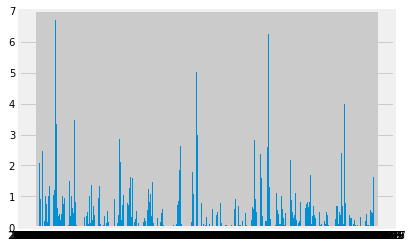

In [16]:
# Sort the dataframe by date
measurement_df.sort_values(by = ["date"])
# Use Pandas Plotting with Matplotlib to plot the data
plt.bar(measurement_df["date"], measurement_df["prcp"])

![precipitation](Images/precipitation.png)

In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data
measure_sum = measurement_df["prcp"].describe()
measure_sum.to_frame()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [18]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(Station.id)).all()

[(9)]

In [19]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_active = session.query(Measurement.station,func.count(Measurement.id)).group_by(Measurement.station).order_by(func.count(Measurement.id).desc()).all()
station_active

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [20]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
summary_active = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station == "USC00519281").all()
summary_active

[(54.0, 85.0, 71.66378066378067)]

(array([ 6., 10., 15., 27., 41., 58., 72., 85., 29.,  8.]),
 array([59. , 61.4, 63.8, 66.2, 68.6, 71. , 73.4, 75.8, 78.2, 80.6, 83. ]),
 <a list of 10 Patch objects>)

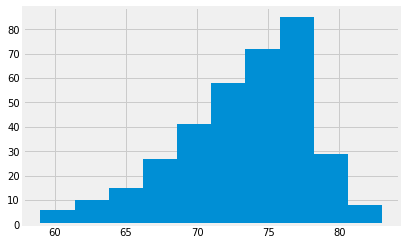

In [25]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
active_tobs = measurement_df.loc[measurement_df["station"] == "USC00519281"]
plt.hist(active_tobs["tobs"])

![precipitation](Images/station-histogram.png)

In [26]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [29]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
sum_temp = calc_temps("2011-02-28", "2011-03-05")
sum_temp

[(61.0, 69.75510204081633, 75.0)]

[]

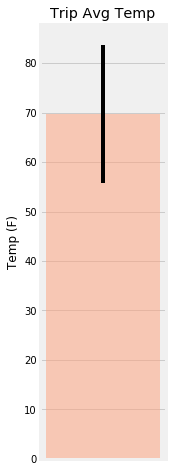

In [87]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
max_temp = sum_temp[0][-1]
min_temp = sum_temp[0][0]
avg_temp = sum_temp[0][1]
x_axis = np.arange(len(sum_temp))

fig, ax = plt.subplots(figsize=(2,8))
ax.bar(x_axis , avg_temp, yerr = (max_temp - min_temp), color = "lightsalmon", alpha = 0.5)

ax.set_title("Trip Avg Temp")
ax.set_ylabel("Temp (F)")
ax.xaxis.grid(False)
ax.set_xticklabels([])

In [96]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
station_prcp_sum = session.query(Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)).group_by(Measurement.station).filter(Measurement.date >= "2011-02-28").filter(Measurement.date <= '2011-03-05').order_by(func.sum(Measurement.prcp).desc()).all()
station_prcp_sum


[('USC00518838',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  20.970000000000006),
 ('USC00519281',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  20.07000000000001),
 ('USC00519523',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  19.709999999999987),
 ('USC00514830',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  17.640000000000008),
 ('USC00516128',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  13.04999999999999),
 ('USC00513117',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  12.96000000000001),
 ('USC00519397',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  12.420000000000003),
 ('USC00511918',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  5.669999999999999),
 ('USC00517948', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, None)]

## Optional Challenge Assignment

In [98]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [125]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals = []
trip_dates = ["02-28", "03-01", "03-02", "03-03", "03-04", "03-05"]
for date in trip_dates:
    normals.append(daily_normals(date)[0])
    
print(normals)
# Set the start and end date of the trip
start_date = dt.date(2014, 6, 20)
end_date   = dt.date(2014, 6, 30)

# Use the start and end date to create a range of dates


dates = [ start_date + dt.timedelta(n) for n in range(int ((end_date - start_date).days))]


str_dates = [date_obj.strftime('%Y-%m-%d') for date_obj in dates]

# Stip off the year and save a list of %m-%d strings
dt.datetime.strptime("2014-06-20", "%Y-%m-%d").strftime("%m-%d")
strip_date = []
for day in str_dates:
    strip_date.append(dt.datetime.strptime(day, "%Y-%m-%d").strftime("%m-%d"))
    
strip_date
# Loop through the list of %m-%d strings and calculate the normals for each date
normals_trip = []
for day in strip_date:
    normals_trip.append(daily_normals(day)[0])
    
normals_trip


[(65.0, 70.65517241379311, 80.0), (64.0, 70.0327868852459, 76.0), (61.0, 70.36666666666666, 78.0), (60.0, 70.06896551724138, 78.0), (57.0, 69.27272727272727, 77.0), (60.0, 67.89090909090909, 76.0)]


[(68.0, 73.96491228070175, 85.0),
 (68.0, 74.75862068965517, 82.0),
 (69.0, 75.15789473684211, 81.0),
 (68.0, 74.54385964912281, 80.0),
 (68.0, 74.96428571428571, 84.0),
 (68.0, 74.10344827586206, 80.0),
 (67.0, 74.21428571428571, 82.0),
 (66.0, 75.01785714285714, 81.0),
 (69.0, 74.88679245283019, 80.0),
 (67.0, 74.91525423728814, 80.0)]

In [136]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_df = pd.DataFrame(normals_trip, columns = ["tmin", "tavg", "tmax"])
trip_df["date"] = str_dates
trip_df = trip_df.set_index("date")
trip_df


,tmin,tavg,tmax
date,,,
2014-06-20,68.0,73.964912,85.0
2014-06-21,68.0,74.758621,82.0
2014-06-22,69.0,75.157895,81.0
2014-06-23,68.0,74.543860,80.0
2014-06-24,68.0,74.964286,84.0
2014-06-25,68.0,74.103448,80.0
2014-06-26,67.0,74.214286,82.0
2014-06-27,66.0,75.017857,81.0
2014-06-28,69.0,74.886792,80.0


(array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]),
 <a list of 10 Text xticklabel objects>)

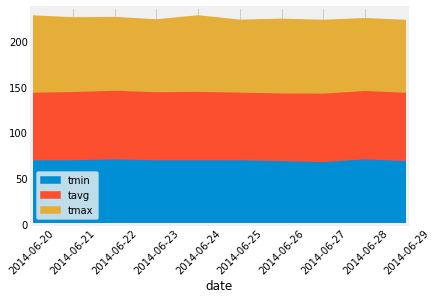

In [138]:
# Plot the daily normals as an area plot with `stacked=False`
trip_df.plot.area()
plt.xticks(rotation = 45)